## Предобучение опций 
Нашей задачей будет создание набора опций, каждая из которых должна быть обучена достигать определенные состояния в задаче такси. Для обучения мы будем использовать QLearningAgent, которого мы написали на одном из прошлых семинаров. 

In [1]:
# импортируем файлы и создаем окружение
import gym
import random
import numpy as np

environment = gym.make('Taxi-v2')
environment.render()


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [2]:
# импортируем классс Q-агента из прошлого занятия
from q_agent import QLearningAgent

### Задание 1 
Разберемся как реализована среда Taxi: https://github.com/openai/gym/blob/master/gym/envs/toy_text/taxi.py

Создадим 4 окружения аналогичных Taxi, в которых целью агента будет достижение одной из точек: R, G, B, Y соответственно. 

In [3]:
class TaxiStepWrapper(gym.Wrapper):
    def __init__(self, env, target_id, target_reward):
        super().__init__(env)
        self._target = target_id
        self._target_reward = target_reward

    def _step(self, action):
        # получаем параметры (state, reward, _, obs),
        # которые передает среда, используя метод step 
        # проверяем является ли состояние завершающим
        # для нашего модифицированного окружения
        # изменяем вознаграждение (reward) и 
        # флаг завершения эпизода (is_done)
        # за каждое действие будем давать вознаграждение 
        # -1, за достижение цели - self._target_reward
        #~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~
        
         
        state, reward, _, obs = self.unwrapped.step(action)
        if self.unwrapped.locs[self._target][:2] == tuple(self.unwrapped.decode(state))[:2]:
            reward = self._target_reward
            is_done = True
        else:
            is_done = False
        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        

        return state, reward, is_done, obs


Проверим нашу обертку (wrapper), используя случайную стратегию.  Порядок точек должен быть  R, G, Y, B.

In [4]:
for target in range(4):
    # создаем окружение с заданным целевым состоянием
    #~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~
    
     
    wrapped_env = TaxiStepWrapper(env=environment, target_id=target, target_reward=50)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    
    # применяем случайную стратегию,
    # пока эпизод не завершится
    #~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~
    
     
    done = False
    wrapped_env.reset(), 0
    while not done:
        s, r, done, _ = wrapped_env.step(random.randint(0, 5))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    

    wrapped_env.render()
    print("state:{s} reward:{r}\n".format(**locals()))


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
state:444 reward:-1

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
state:446 reward:-1

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
state:211 reward:-1

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
state:109 reward:-1



In [5]:
# воспользуемся методом play_and_train, 
# который мы реализовали на прошлом семинаре
def play_and_train(env, agent, t_max=10 ** 4):
    total_discounted_reward = 0.0
    s = env.reset()
    for t in range(t_max):
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)
        agent.update(s, a, next_s, r)
        s = next_s
        total_discounted_reward += r
        if done:
            break
    return total_discounted_reward


### Задание 2 
1. Обучим агентов на созданных нами окружениях.
2. Создадим упрощенный вариант опций, каждая опция будет иметь стратегию, множество начальных состояний и множество конечных состояний.

In [6]:
n_actions = environment.action_space.n

# параметры, которые будут использовать агенты
params = {"alpha": 0.1, "epsilon": 0.1, 
"gamma": 0.99, "get_legal_actions": lambda s: range(4)}

# создаем агентов 
agents_for_options = [QLearningAgent(**params)\
                      for _ in range(4)]

for index in range(4):
    # создаем окружение с заданным целевым состоянием, 
    # используя созданных окружения обучаем агентов
    #~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~
    
     
    wrapped_env = TaxiStepWrapper(env=environment, target_id=index, target_reward=50)
    for _ in range(2500):
        play_and_train(env=wrapped_env, agent=agents_for_options[index])
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    


In [7]:
# реализуем класс опции
class Option:
    def __init__(self, policy, termination_prob, initial):
        self.policy = policy
        self.termination_prob = termination_prob
        self.initial_states = initial

    def can_start(self, state):
        return state in self.initial_states

    def terminate(self, state):
        return random.random() <= self.termination_prob[
            state]

    def get_action(self, state):
        return self.policy.get_action(state)

In [8]:
options = []
for index, agent in enumerate(agents_for_options):
    # Создаем словарь termination_prob, в котором каждому 
    # состоянию  нужно задать вероятность завершения 
    # опции. В нашем случае зададим 1.0 или 0.0, 
    # в зависимости от состояния.
    # Создаем множество initial, добавляем в него 
    # состояния, из которых опция может быть 
    # вызвана (все кроме целевых)
    termination_prob = {}
    initial_states = set()
    termination_states = set()
    #~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~
    
     
    for state in range(environment.observation_space.n):
        if environment.unwrapped.locs[index][:2] == tuple(environment.unwrapped.decode(state))[:2]:
            initial_states.add(state)
        else:
            termination_states.add(state)
    for state in range(environment.observation_space.n):
        termination_prob[state] = float(not state in termination_states)
    initial = set(termination_states)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    

    options.append(Option(policy=agent, \
    termination_prob=termination_prob, initial=initial))


### Задание 3
Напишем функцию, которая будет запускать опцию и возвращать дисконтированное вознаграждение, опираясь на число совершенных действий
$$ R = r_{1} + \gamma r_{2} + \gamma^{2} r_{3} + \dots + \gamma^{t-1}r_{t}$$

In [9]:
def apply_option(option, gamma, env, debug=False):
    reward = 0
    steps = 0

    if not option.can_start(env.unwrapped.s):
        raise KeyError
    
    # Взаимодействуем со средой пока опция или окружение 
    # не завершится, считаем дисконтированное 
    # вознаграждение reward (используем steps),
    # также добавим render окружения, при флаге - debug
    #~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~
    
     
    
    # получаем состояние среды
    s, d, obs = env.unwrapped.s, False, None
    while True:
        act = option.get_action(s)

        s, r, d, obs = env.step(act)
        reward += r * (gamma ** steps)
        steps += 1
        if debug:
            env.render()
        if option.terminate(s):
            if debug:
                print("Option terminated")
            break
        if d:
            if debug:
                print('Environment is done')
            break
    
    if debug:
        print("SMDP reward: {reward}".format(**locals()))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # state, reward, is_done, obs
    return s, reward, d, obs


In [10]:
# проверим работу метода
env = gym.make('Taxi-v2')
s = env.reset()

r = apply_option(options[0], 0.99, env, debug=True)


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |


Кажется, что все хорошо, но мы забыли рассмотреть вариант, когда пассажир может находиться в такси! Переведем среду в состояние, где пассажира мы уже подобрали и посмотрим, как ведет себя  одна из опций.

In [11]:
s = env.reset()
env.unwrapped.s = 499
env.render()
print("\n" * 2)
r = apply_option(options[0], 0.99, env, debug=True)


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+




+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | :_|
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : 

### Задание 4
Видим, что опции не обучились действовать в такой ситуации. 
Исправим нашу функцию обучения так, чтобы опции работали корректно для всех возможных состояний среды и сгенерируем их заново.

In [12]:
def play_and_train_modified(env, agent, t_max=10 ** 4):
    # Зададим новую функцию play_and_train, которая 
    # в качестве начального состояния выбирает любое 
    # состояние среды,включая и то, когда пассажир 
    # находится в такси

    total_discounted_reward = 0.0
    s = env.reset()
    
    # Выбираем случайное состояние среды
    # (используем метод env.uwrapped)
    #~~~~~~~~~~ Решение ~~~~~~~~~~~~~~~
    
     
    env.unwrapped.s = random.randint(0, 499)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    

    for t in range(t_max):
        a = agent.get_action(s)
        next_s, r, done, _ = env.step(a)
        agent.update(s, a, next_s, r)
        s = next_s
        total_discounted_reward += r
        if done:
            break
    return total_discounted_reward


for index in range(4):
    for _ in range(5250):
        wrapped_env = TaxiStepWrapper(env=environment, 
                target_id=index, target_reward=50)
        play_and_train_modified(env=wrapped_env, 
                agent=agents_for_options[index])


Запустим данную ячейку несколько раз и убедимся, что агент обучился для всех случаев!

In [13]:
env = environment
s = env.reset()

env.unwrapped.s = random.randint(0, 499)
apply_option(options[0], 0.99, env, debug=True)


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |

(413, -86.6020325142037, True, {'prob': 1.0, 'TimeLimit.truncated': True})

### Объединение в иерархию
Реализуйте иерархию, используя элементарные (опции из одного действия) и обученные опции.

#### Добавим элементарные опции (опции из одного действия: посадка и высадка пассажира):

In [14]:
# для действий 4-5 (pickup, dropoff) создаем 
# элементарные опции:
class OneActionAgent:
    def __init__(self, action):
        self.action = action
    
    def get_action(self, state):
        return self.action
    
    def update(*args, **kwargs):
        pass

options = options[:4]    
for action in range(4, 6):
    # элементарная опция начинается в любом состоянии, 
    # выполняет любое действие и завершается
    initial = set(range(environment.observation_space.n))
    termination_prob = {_:1.0 \
    for _ in  range(environment.observation_space.n)}   
    options.append(Option(policy=OneActionAgent(action), 
    termination_prob=termination_prob, initial=initial))

#### Проверим элементарные опции:

In [15]:
env = environment
s = env.reset()

env.unwrapped.s = random.randint(0, 499)
apply_option(options[0], 0.99, env, debug=True)
apply_option(options[4], 0.99, env, debug=True)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: 

(451, -10.0, True, {'prob': 1.0, 'TimeLimit.truncated': True})

#### Реализуем обертку для окружения, которая вместо действий применяет опции (в качестве входа - список опций):

In [16]:
class OptionTaxiStepWrapper(gym.Wrapper):
    def __init__(self, env, options, gamma=0.99):
        self.options = options
        self.gamma = gamma
        super().__init__(env)

    def _step(self, action):
        state, reward, is_done, obs =\
        apply_option(self.options[action],
            self.gamma, self.unwrapped)
        return state, reward, is_done, obs


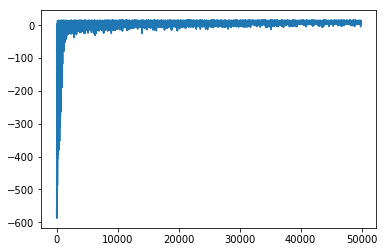

In [17]:
option_agent = QLearningAgent(alpha=0.1, epsilon=0.1,
                              gamma=0.99,
                              get_legal_actions=lambda
                                  s: range(len(options)))

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

# создаем окружение, использующее опции
env = OptionTaxiStepWrapper(gym.make('Taxi-v2'),
                            options=options)
rewards = []
for episode in range(50000):
    rewards.append(
        play_and_train(env=env, agent=option_agent))

    if episode % 100 == 0:
        clear_output(True)
        option_agent.epsilon *= 0.99
        plt.plot(rewards)
        plt.show()